The problem is a multisite (many store), multivariate (many features), multistep (forecast for many date points) time series forecasting task.\

Solution is based on a Encoder-Decoder RNN model. It takes 120 length input sequences for each date point and outputs 47 date points. Input sequences consist of time-dependent and time-independent (categorical and numerical features that are static for a store). Time-independent features are concatenated with time-dependent ones and broadcasted. Categorical features are one-hot encoded. \
Data is scaled, target feature is log transformed before.\
RMSE loss is chosen as a loss for model evaluation.

There are two modes of a model training: 'val' and 'test'. 'Val' mode is used for model tuning (chose of parameters), while 'test' mode is used for a final model training.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt

In [3]:
from utils import preprocessing_utils, general_utils

0it [00:00, ?it/s]

Load datasets: train, test, store

In [201]:
DATA_PATH = 'data/'

In [202]:
train_df = pd.read_csv(DATA_PATH + 'train.csv', low_memory=False)
test_df = pd.read_csv(DATA_PATH + 'test.csv', low_memory=False)
store_df = pd.read_csv(DATA_PATH + 'store.csv')

In [203]:
train_df['Date'] = pd.to_datetime(train_df['Date'], infer_datetime_format=True)
test_df['Date'] = pd.to_datetime(test_df['Date'], infer_datetime_format=True)

In [204]:
print(train_df['Date'].min(), train_df['Date'].max())
print(test_df['Date'].min(), test_df['Date'].max())

2013-01-01 00:00:00 2015-07-31 00:00:00
2015-08-01 00:00:00 2015-09-17 00:00:00


In [8]:
store_sample = np.random.choice(1000, 100)

In [9]:
train_df = train_df[train_df['Store'].isin(store_sample)].reset_index(drop=True)
test_df = test_df[test_df['Store'].isin(store_sample)].reset_index(drop=True)
store_df = store_df[store_df['Store'].isin(store_sample)].reset_index(drop=True)


We have data 2013, 2014 and 2015 till 2015-07-31. \
We need to predict sales for the next 1,5 month i.e. 47 days.

## Data Preparation

1. 1115 unique stores. All stores from a test set are listed in a train set. Although train set contains extra stores
2. There is only 1 record per 1 date. (Store, Date) is a unique identifier
3. History of sales contains 941 days (except 1 store). Start date 2013-01-01 (2013-01-02) and end date 2015-07-31
   Based on 941 records of sales we need to make predictions for the next 47 days

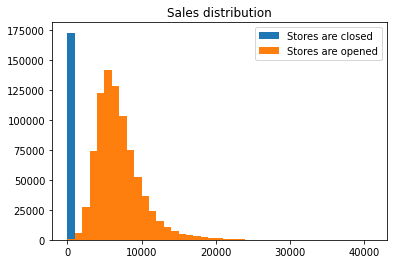

In [207]:
plt.hist(train_df[train_df['Open'] == 0]['Sales'], bins=np.arange(train_df['Sales'].min(), train_df['Sales'].max(), step=1000))
plt.hist(train_df[train_df['Open'] == 1]['Sales'], bins=np.arange(train_df['Sales'].min(), train_df['Sales'].max(), step=1000))
plt.legend(['Stores are closed', 'Stores are opened'])
plt.title('Sales distribution')
plt.show()

Fill missing values. Missing values in test dataset 'Open' feature. No pattern, fill with previous value

In [10]:
test_df['Open'] = test_df.groupby('Store')['Open'].ffill()
test_df['Open'].fillna(0, inplace=True)

In [11]:
test_df.isna().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Almost 17% of sales records are 0s. These values can bias a normal distribution of non zero sales values (which is proved by a histogram). Records are removed for the dates when stores were closed. Records with zero sales values when stores were not closed are kept, because it's caused by external factors.\

1. Select indeces of records for the dates when stores were closed.
2. Save information about promos and holidays on that dates.
3. Fill the gaps in date range
3. Fill the gaps in sales and customers values by interpolation
4. Fill missing values in promos and holidays from the previously saved data where it's possible
5. Fill left missing values with the nearest values

In [12]:
train_df = preprocessing_utils.interpolate_sales_customers(train_df, method='nearest')

2021-02-25 14:44:20,144 | INFO : Shape before removal: (86914, 9)
2021-02-25 14:44:20,290 | INFO : Shape after removal: (72337, 9)
2021-02-25 14:44:20,544 | INFO : Shape after filling date gaps: (89397, 9)
2021-02-25 14:44:21,137 | INFO : Number of missing values in df: 0


In [13]:
train_df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2013-01-02,9,3.0,4903.0,481.0,1.0,0.0,0,1.0
1,2013-01-03,9,4.0,4602.0,453.0,1.0,0.0,0,1.0
2,2013-01-04,9,5.0,4798.0,497.0,1.0,0.0,0,1.0
3,2013-01-05,9,6.0,4254.0,450.0,1.0,0.0,0,0.0
4,2013-01-06,9,6.0,4254.0,450.0,0.0,0.0,0,0.0


### Preprocess store data

In [14]:
store_df = preprocessing_utils.fill_nans_store_df(store_df)

2021-02-25 14:44:21,210 | INFO : Fill NaN in CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear with 0
2021-02-25 14:44:21,215 | INFO : Fill NaN in Promo2SinceWeek, Promo2SinceYear with 0
2021-02-25 14:44:21,216 | INFO : Fill NaN in PromoInterval with ""


In [15]:
DATA_PATH = 'largefiles/'

In [16]:
store_df, store_label_encoder = preprocessing_utils.transform_store_df(store_df, DATA_PATH + 'store_cat_cols_le')

2021-02-25 14:44:21,475 | INFO : Encode labels in ['StoreType', 'Assortment', 'PromoInterval']
2021-02-25 14:44:21,480 | INFO : Transform log1p CompetitionDistance
2021-02-25 14:44:21,481 | INFO : Transform date features
2021-02-25 14:44:21,490 | INFO : Save label encoder to largefiles/store_cat_cols_le.pkl


In [17]:
store_label_encoder

{'StoreType': {'a': 0, 'b': 1, 'c': 2, 'd': 3},
 'Assortment': {'a': 0, 'b': 1, 'c': 2},
 'PromoInterval': {'': 0,
  'Feb,May,Aug,Nov': 1,
  'Jan,Apr,Jul,Oct': 2,
  'Mar,Jun,Sept,Dec': 3}}

### Preprocess train/test

In [18]:
test_df['Sales'] = np.nan
test_df['Customers'] = np.nan
sales_df = pd.concat([train_df, test_df], ignore_index=True)

In [19]:
train_df['StateHoliday'].unique()

array(['0', 'b', 'a', 'c'], dtype=object)

In [20]:
sales_df, sales_label_encoder = preprocessing_utils.transform_sales_df(sales_df, DATA_PATH + 'sales_cat_cols_le')

2021-02-25 14:44:22,464 | INFO : Add Day, Month, Year features
2021-02-25 14:44:22,489 | INFO : Transform date features
2021-02-25 14:44:22,569 | INFO : Encode StateHoliday
2021-02-25 14:44:22,569 | INFO : Encode labels in ['StateHoliday']
2021-02-25 14:44:22,590 | INFO : Save label encoder to largefiles/sales_cat_cols_le.pkl


In [21]:
data = sales_df.merge(store_df, on='Store', how='left')

In [22]:
data.drop(['Year', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'Id'], axis=1, inplace=True)

In [23]:
data.shape

(92613, 23)

In [24]:
data.isna().sum()

Date                                0
Store                               0
Sales                            3216
Customers                        3216
Open                                0
Promo                               0
StateHoliday                        0
SchoolHoliday                       0
DayOfWeek_sin                       0
DayOfWeek_cos                       0
Month_sin                           0
Month_cos                           0
Day_sin                             0
Day_cos                             0
StoreType                           0
Assortment                          0
CompetitionDistance                 0
Promo2                              0
PromoInterval                       0
CompetitionOpenSinceMonth_sin       0
CompetitionOpenSinceMonth_cos       0
Promo2SinceWeek_sin                 0
Promo2SinceWeek_cos                 0
dtype: int64

In [25]:
data.to_pickle(DATA_PATH + 'unscaled_sales_data.pickle')

## Prepare data for model training

Validation strategy: Side-by-side split\
Dataset splits into independent parts, one part used strictly for training and another part used strictly for validation.

Data range 2013 to 2015-07-31. \
Validation Model is trained on 2013 to 2015 data and predict 47 days of 2015 data.
The best performing model will be trained on 2013 to 2015-07-31 data to predict 47 days from 2015-08-01 without validation. \

In the validation model sequences of the last 47 days of 2014 shouldn't be included because it contains 2015 values in y.

In [26]:
data['Date'].min()

Timestamp('2013-01-01 00:00:00')

In [27]:
data['Date'].max()

Timestamp('2015-09-17 00:00:00')

In [28]:
full_range = pd.date_range(data['Date'].min(), data['Date'].max())

In [29]:
full_range[full_range<'2014-11-15']

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2014-11-05', '2014-11-06', '2014-11-07', '2014-11-08',
               '2014-11-09', '2014-11-10', '2014-11-11', '2014-11-12',
               '2014-11-13', '2014-11-14'],
              dtype='datetime64[ns]', length=683, freq='D')

### Normalize Data

'Sales' and 'Customers' features are log transformed to make values closer to each other.\
After that features are normalized for future usage in RNN model.\
In 'val' mode scaling parameters are estimated only on the train part of a dataset. In 'test' mode scaling parameters are estimated on train and validation parts.

In [ ]:
mode = 'val'

In [30]:
cols_to_scale = {'td': ['Sales', 'Customers'],
                 'ti': ['Assortment', 'CompetitionDistance']
                }
val_date = None

if mode == 'val':
    val_date = '2014-11-15'

In [31]:
scaled_data, scale_map = preprocessing_utils.scale_data(data,
                                                        DATA_PATH + f'scalemap',
                                                        DATA_PATH + f'scaled_data_{mode}',
                                                        cols_to_scale,
                                                        mode=mode,
                                                        val_date=val_date
                                                       )

2021-02-25 14:44:26,356 | INFO : Log Transform Sales and Customers
2021-02-25 14:44:26,361 | INFO : Select records for scaler fitting
2021-02-25 14:44:26,368 | INFO : Start scaling time-dependant features ['Sales', 'Customers']
100%|██████████| 95/95 [00:01<00:00, 49.37it/s]
2021-02-25 14:44:28,302 | INFO : Start scaling time-independant features ['Assortment', 'CompetitionDistance']
2021-02-25 14:44:28,319 | INFO : Convert data formats to reduce memory usage
2021-02-25 14:44:28,388 | INFO : Save pickle files


Mem. usage decreased to  4.95 Mb (74.1% reduction)


In [32]:
scale_map.keys()

dict_keys(['Sales', 'Customers', 'Assortment', 'CompetitionDistance'])

In [33]:
scale_map

defaultdict(dict,
            {'Sales': {9: {'mean': 8.698446806012091,
               'std': 0.21241408104535603},
              12: {'mean': 8.855684846927902, 'std': 0.2428844756175327},
              38: {'mean': 8.650564811281642, 'std': 0.28281276280698836},
              39: {'mean': 8.328432395887107, 'std': 0.37032603924206753},
              59: {'mean': 8.440380496713683, 'std': 0.43480713694920614},
              62: {'mean': 8.65331216657392, 'std': 0.3374192725188714},
              68: {'mean': 8.892804701900864, 'std': 0.21819438574484143},
              72: {'mean': 8.399319346687017, 'std': 0.5607470761191088},
              80: {'mean': 8.903489496644625, 'std': 0.2237088633949896},
              95: {'mean': 8.855238475538123, 'std': 0.3281397147742131},
              137: {'mean': 9.01468153703129, 'std': 0.2804988736341931},
              163: {'mean': 8.87571405205922, 'std': 0.21207817877421023},
              165: {'mean': 8.31161813520819, 'std': 0.31781753981

In [34]:
len(scale_map['Sales'])

95

In [35]:
len(scale_map['Assortment'])

2

### Build data sequences

In [36]:
scaled_data.columns

Index(['Date', 'Store', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin',
       'Month_cos', 'Day_sin', 'Day_cos', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'PromoInterval',
       'CompetitionOpenSinceMonth_sin', 'CompetitionOpenSinceMonth_cos',
       'Promo2SinceWeek_sin', 'Promo2SinceWeek_cos', 'Sales_mean',
       'Customers_mean', 'Assortment_mean', 'CompetitionDistance_mean'],
      dtype='object')

In [37]:
n_steps_in = 120
input_data_filename = DATA_PATH + f'scaled_data_{mode}'
output_data_filename = DATA_PATH + f'sequence_data_{mode}'

In [38]:
input_data_filename

'largefiles/scaled_data_val'

In [39]:
output_data_filename

'largefiles/sequence_data_val'

In [ ]:
# run sequence_builder.py to construct sequences of features

In [ ]:
# provide input_data_filename  output_data_filename n_steps_in as parameters

In [40]:
! python build_sequence.py 'largefiles/scaled_data_val' 'largefiles/sequence_data_val' 120

0it [00:00, ?it/s]2021-02-25 14:44:30,285 | INFO : largefiles/scaled_data_val
2021-02-25 14:44:30,286 | INFO : Time-dependant features: ['Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos']
2021-02-25 14:44:30,286 | INFO : Time-independent features: ['Date', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2', 'PromoInterval', 'CompetitionOpenSinceMonth_sin', 'CompetitionOpenSinceMonth_cos', 'Promo2SinceWeek_sin', 'Promo2SinceWeek_cos']
2021-02-25 14:44:30,286 | INFO : Target Feature: Sales
2021-02-25 14:44:30,286 | INFO : Load pickle file: largefiles/scaled_data_val
2021-02-25 14:44:30,292 | INFO : Start building sequences

 94%|████████████████████████████████████████▎  | 15/16 [01:52<00:07,  7.88s/it]


100%|███████████████████████████████████████████| 15/15 [02:01<00:00,  8.08s/it]

0it [02:01, ?it/s]██████████████████████████████| 16/16 [02:01<00:00,  7.81s/it]
0it [02:02, ?it/s]

100%|███████████████████████████████████████████| 16/16 [02:07<00:00,  7.96s/it]
0it [02:07, ?it/s]
100%|███████████████████████████████████████████| 16/16 [02:07<00:00,  7.97s/it]
0it [02:07, ?it/s]
0it [02:07, ?it/s]
0it [02:07, ?it/s]
100%|███████████████████████████████████████████| 16/16 [02:08<00:00,  8.01s/it]
0it [02:08, ?it/s]

100%|█████████████████████████████████████████████| 6/6 [02:09<00:00, 21.52s/it]
(76843, 13)
2021-02-25 14:46:39,979 | INFO : Save data to largefiles/sequence_data_val


In [41]:
seq_data = general_utils.open_pickle_file(output_data_filename)

### Prepare pytorch dataloader

In [42]:
from utils.preprocessing_utils import StoreDataset

In [43]:
from torch.utils.data import Dataset, DataLoader

In [44]:
val_date

'2014-11-15'

In [45]:
pd.to_datetime('2013-04-01') - pd.to_datetime('2013-01-01')

Timedelta('90 days 00:00:00')

In [46]:
test_sequence_data = seq_data[seq_data['Date'] == '2015-08-01']

In [47]:
if mode == 'val':
    train_sequence_data = seq_data[(seq_data['Date'] >= '2013-04-01') & (seq_data['Date'] <= val_date)]
    valid_sequence_data = seq_data[(seq_data['Date'] > val_date) & (seq_data['Date'] <= '2015-01-01')]
else:    
    train_sequence_data = seq_data[(seq_data['Date'] >= '2013-04-01') & (seq_data['Date'] <= '2015-07-31') ]
    valid_sequence_data = pd.DataFrame()

In [48]:
print(train_sequence_data.shape, valid_sequence_data.shape, test_sequence_data.shape)

(53487, 13) (4465, 13) (67, 13)


In [49]:
cat_columns = ['StoreType', 'Promo2', 'PromoInterval']
num_columns = ['CompetitionDistance', 'CompetitionOpenSinceMonth_sin', 'CompetitionOpenSinceMonth_cos',
               'Promo2SinceWeek_sin', 'Promo2SinceWeek_cos', 
#                'Sales_mean',
#                'Customers_mean', 'Assortment_mean', 'CompetitionDistance_mean'
              ]

In [50]:
train_dataset = StoreDataset(cat_columns=cat_columns, num_columns=num_columns, embed_vector_size=50, ohe_cat_columns=True )
valid_dataset = StoreDataset(cat_columns=cat_columns, num_columns=num_columns, embed_vector_size=50, ohe_cat_columns=True )
test_dataset = StoreDataset(cat_columns=cat_columns, num_columns=num_columns, embed_vector_size=50, ohe_cat_columns=True)

2021-02-25 14:46:42,397 | INFO : Create Dataset object
2021-02-25 14:46:42,398 | INFO : Create Dataset object
2021-02-25 14:46:42,399 | INFO : Create Dataset object


In [51]:
train_dataset.load_sequence_data(train_sequence_data)
valid_dataset.load_sequence_data(valid_sequence_data)
test_dataset.load_sequence_data(test_sequence_data)

2021-02-25 14:46:42,422 | INFO : Load data
2021-02-25 14:46:42,427 | INFO : Load data
2021-02-25 14:46:42,435 | INFO : Load data


In [52]:
train_dataset.process_cat_columns()

In [53]:
valid_dataset.process_cat_columns()

In [54]:
test_dataset.process_cat_columns()

In [55]:
len_cat = {'le': len(num_columns), 'ohe' : sum([x for x in zip(*train_dataset.cat_embed_shape)][0])}

In [56]:
12 + len(num_columns) + len_cat['ohe']

27

In [57]:
batch_size = 256

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
print(len(train_dataloader), len(valid_dataloader))

209 18


In [58]:
X, y = next(iter(train_dataloader))
print(len(X))
print(X[0].shape)

256
torch.Size([120, 27])


In [59]:
y.shape

torch.Size([256, 47])

### Create model

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim

from utils.model_utils import RNNEncoder, DecoderCell, EncoderDecoderWrapper, TorchTrainer
# 'cpu'/'cuda'
device = 'cpu'

encoder = RNNEncoder(
    input_feature_len=train_dataset[0][0].shape[1], 
    rnn_num_layers=32, 
    hidden_size=128,  
    sequence_len=train_dataset[0][0].shape[0],
    bidirectional=False,
    device=device,
    rnn_dropout=0.1
)

decoder_cell = DecoderCell(
    input_feature_len=1,
    hidden_size=128,
)




loss_function = nn.MSELoss()


encoder = encoder.to(device)
decoder_cell = decoder_cell.to(device)

model = EncoderDecoderWrapper(
    encoder,
    decoder_cell,
    output_size=train_dataset[0][1].shape[0],
    teacher_forcing=0,
    sequence_len=train_dataset[0][0].shape[0],
    decoder_input=False,
    device='cpu'
)

model = model.to(device)

encoder_optimizer = optim.AdamW(encoder.parameters(), lr=1e-3, weight_decay=1e-2)
decoder_optimizer = optim.AdamW(decoder_cell.parameters(), lr=1e-3, weight_decay=1e-2)

encoder_scheduler = optim.lr_scheduler.OneCycleLR(encoder_optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=6)
decoder_scheduler = optim.lr_scheduler.OneCycleLR(decoder_optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=6)

model_optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)

0it [00:00, ?it/s]


In [61]:
trainer = TorchTrainer(
    'encdec_ohe_std_mse_wd1e-2_do2e-1_test_hs100_tf0_adam',
    model, 
    [encoder_optimizer, decoder_optimizer], 
    loss_function, 
    [encoder_scheduler, decoder_scheduler],
    device, 
    scheduler_batch_step=True,
    pass_y=True,
    #additional_metric_fns={'SMAPE': smape_exp_loss}
)

  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.81E-03


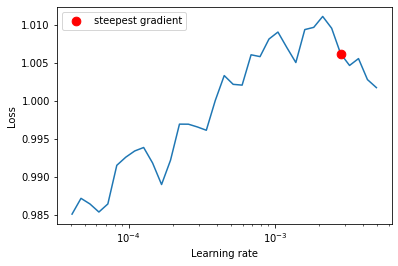

In [62]:
trainer.lr_find(train_dataloader, model_optimizer, start_lr=1e-5, end_lr=1e-2, num_iter=50)

In [63]:
vd = valid_dataloader if mode == 'val' else None
trainer.train(1, train_dataloader, vd, resume_only_model=True, resume=True)

loss 1.0056:  30%|██▉       | 62/209 [15:03<34:51, 14.23s/it]


loss 0.9646:  60%|█████▉    | 125/209 [30:05<20:11, 14.42s/it]


loss 1.0753:  89%|████████▉ | 187/209 [49:41<07:50, 21.38s/it]


loss 0.9477: 100%|██████████| 209/209 [58:46<00:00, 24.87s/it]
                                                              
  0%|          | 0/18 [00:00<?, ?it/s]

Training loss at epoch 1 - 0.9883468782901764



100%|██████████| 1/1 [1:00:26<00:00, 3626.02s/it]A

{}
Valid loss at epoch 1 - 1.2543114721775055
saved checkpoint for epoch 1


In [64]:
trainer._load_checkpoint(only_model=True)

loaded checkpoint for epoch - 1


1

In [65]:
if mode == 'val':
    valid_predictions = trainer.predict(valid_dataloader)

100%|██████████| 18/18 [01:26<00:00,  4.81s/it]


In [66]:
test_predictions = trainer.predict(test_dataloader)

100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


In [68]:
range(len(valid_sequence_data))

range(0, 4465)

In [69]:
valid_sequence_data.index = range(len(valid_sequence_data))
test_sequence_data.index = range(len(test_sequence_data))

In [89]:
if mode == 'val':
    valid_sequence_data['predictions'] = pd.Series(valid_predictions.tolist())
test_sequence_data['predictions'] = pd.Series(test_predictions.tolist())

/Users/kfrid/Projects/takehome_test/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/kfrid/Projects/takehome_test/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [90]:
mode

'val'

In [91]:
if mode == 'val':
    valid_sequence_data['X'] = valid_sequence_data['x_sequence'].apply(lambda x: x[:, 0])
    valid_sequence_data['Y'] = valid_sequence_data['y_sequence'].apply(lambda x: x[:, 0])


/Users/kfrid/Projects/takehome_test/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/kfrid/Projects/takehome_test/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [75]:
valid_sequence_data['x_sequence'][0].shape

(120, 12)

In [78]:
valid_sequence_data['X'][0].shape

(120,)

In [82]:
len(valid_sequence_data['predictions'][0])

47

### Rescale data

In [84]:
from utils.preprocessing_utils import rescale_data

In [153]:
if mode == 'val':
    valid_rescaled = rescale_data(scale_map, valid_sequence_data, columns=['X', 'Y', 'predictions'])
test_rescaled = rescale_data(scale_map, test_sequence_data, columns=['predictions'])


2021-02-25 16:49:01,083 | INFO : Start rescaling
100%|██████████| 95/95 [00:01<00:00, 59.47it/s]
2021-02-25 16:49:02,693 | INFO : Start rescaling
100%|██████████| 67/67 [00:00<00:00, 83.64it/s]


In [98]:
if mode == 'val':
    valid_sequence_data = valid_rescaled
test_sequence_data = test_rescaled

In [154]:
valid_rescaled['predictions'] = valid_rescaled['predictions'].apply(np.array)
valid_rescaled['X'] = valid_rescaled['X'].apply(np.array)
valid_rescaled['Y'] = valid_rescaled['Y'].apply(np.array)

Predictions for a validation part. Following results are received from 1 epoch model training on 2 features. Results are provided as an example and do not pretend to be the best solution 

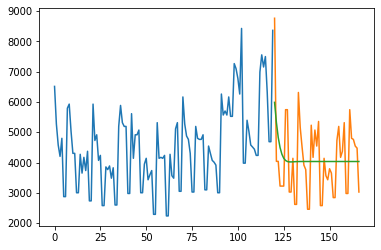

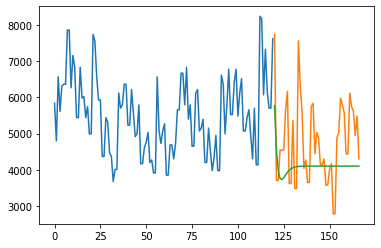

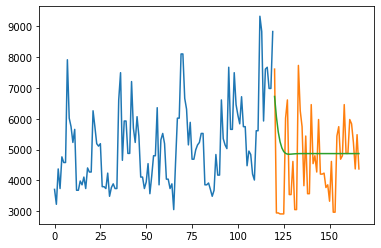

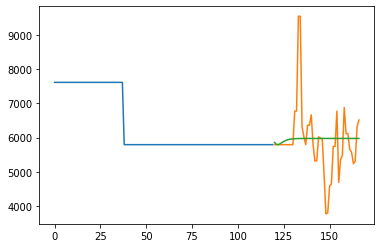

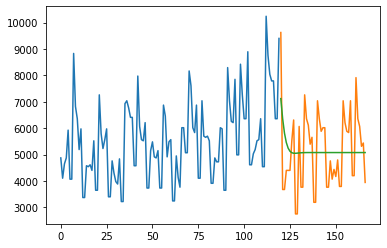

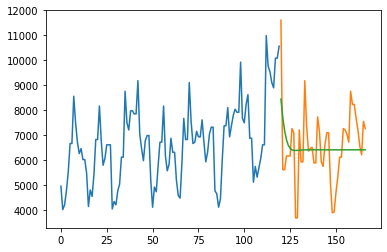

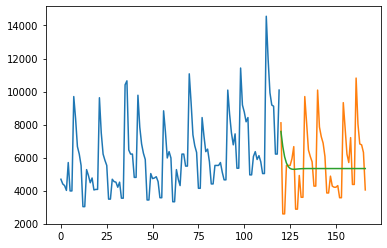

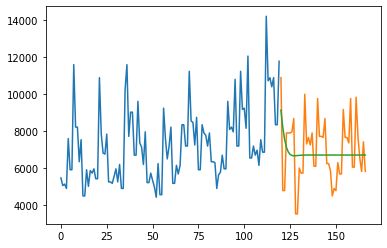

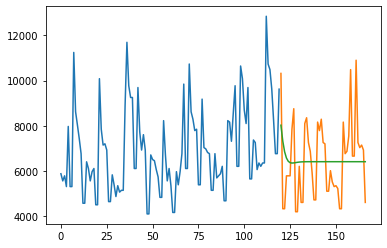

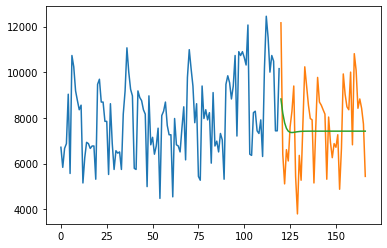

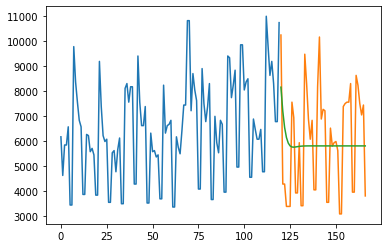

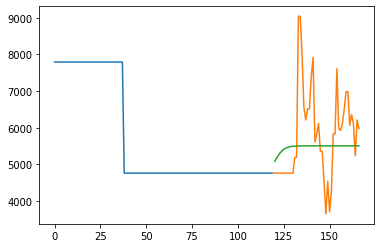

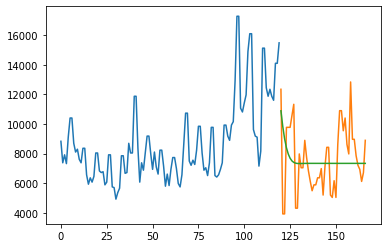

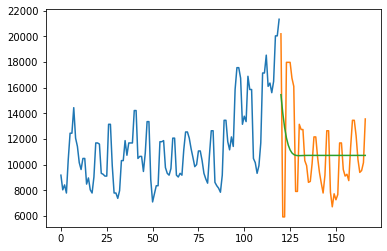

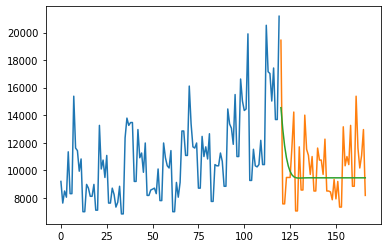

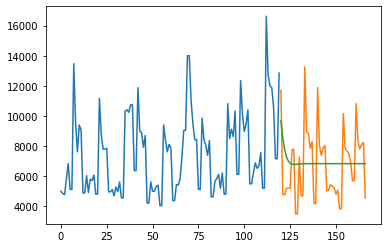

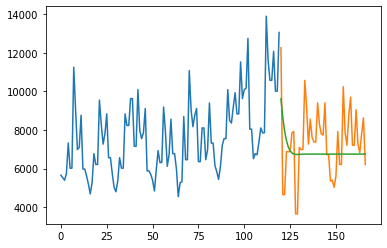

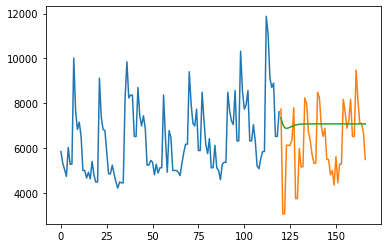

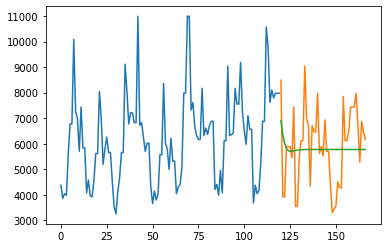

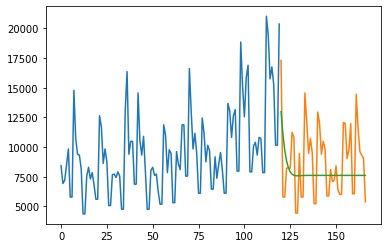

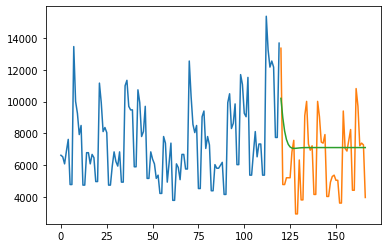

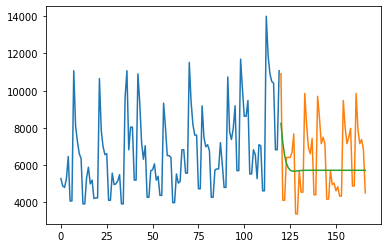

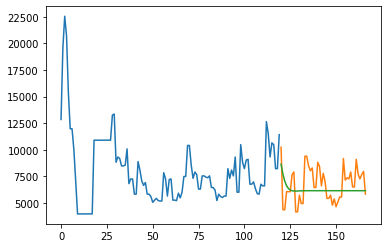

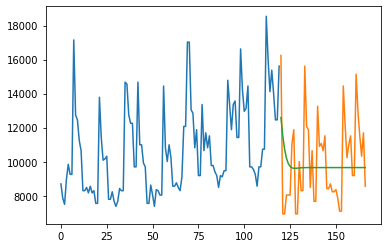

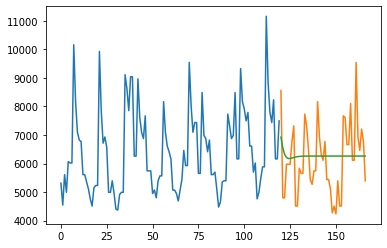

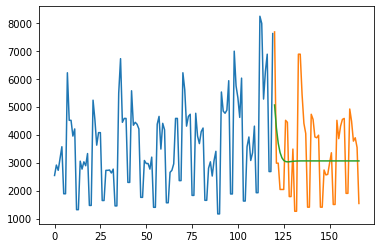

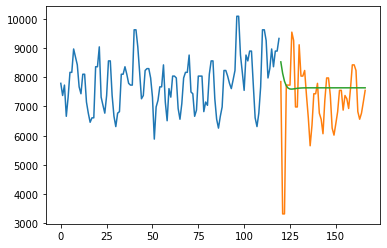

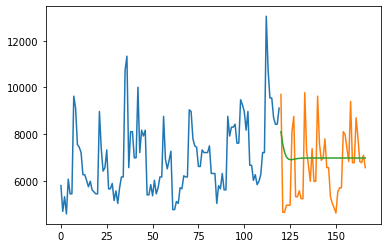

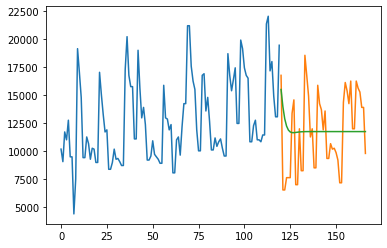

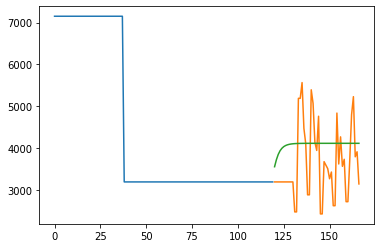

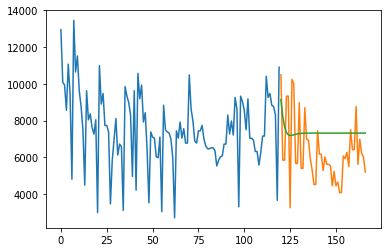

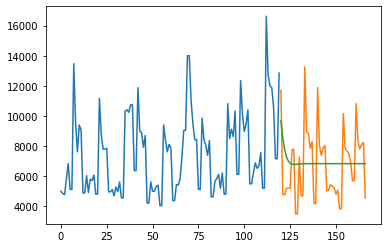

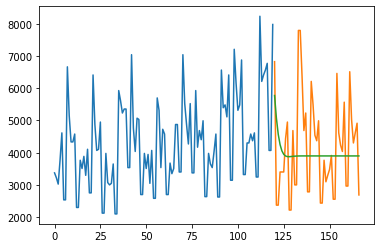

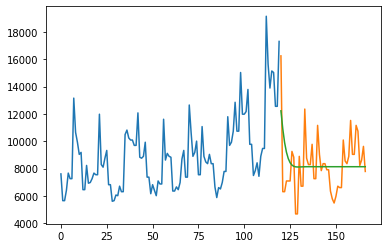

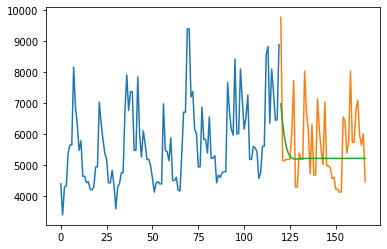

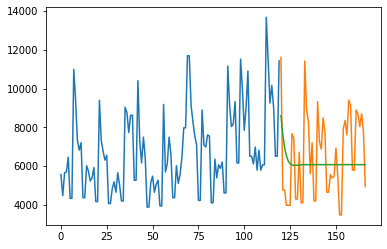

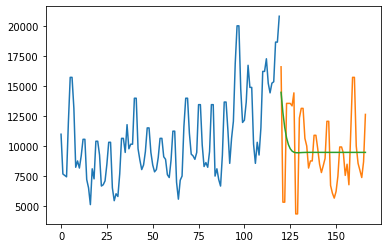

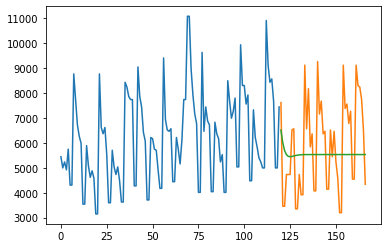

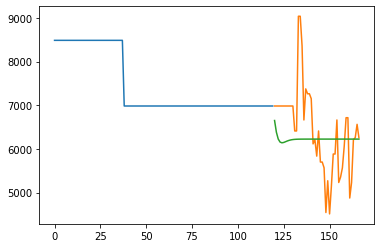

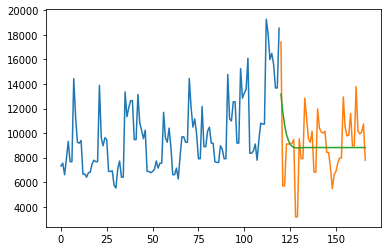

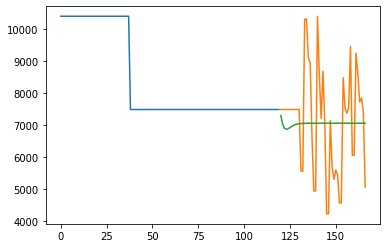

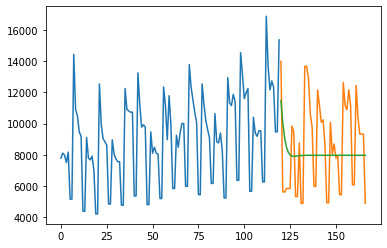

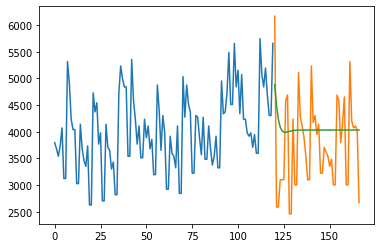

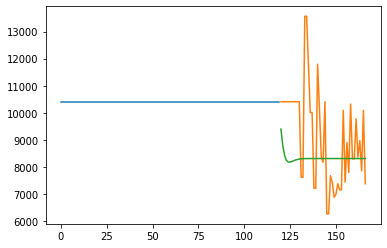

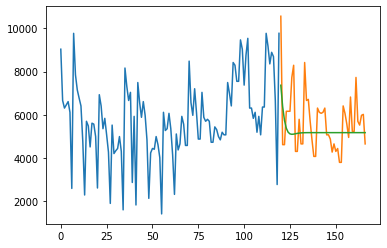

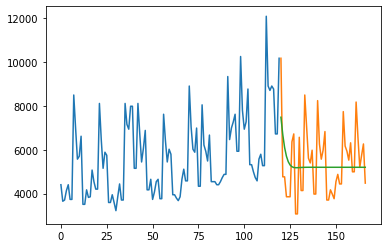

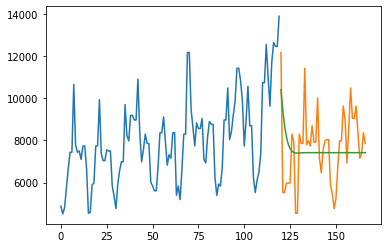

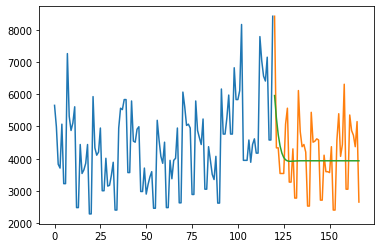

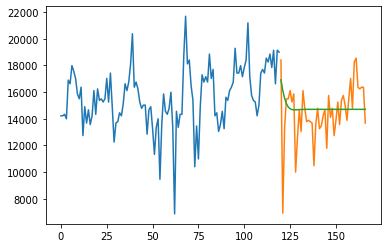

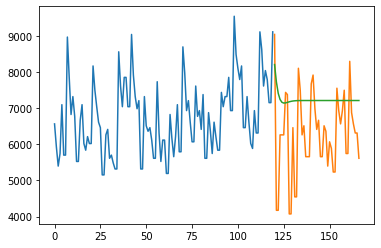

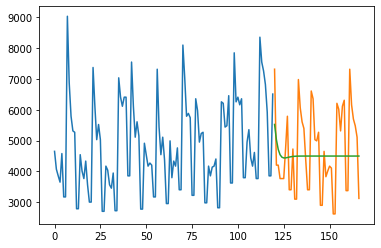

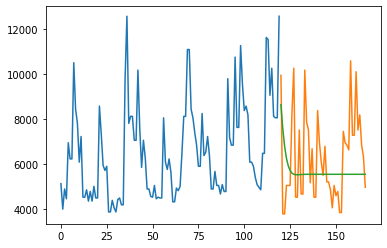

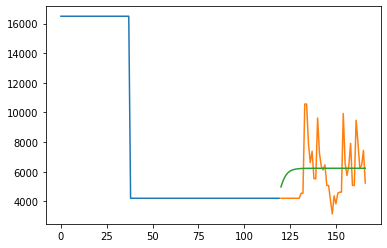

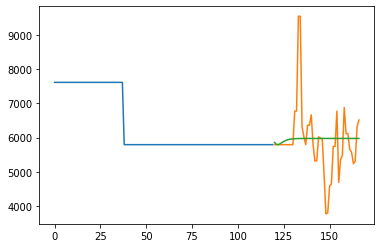

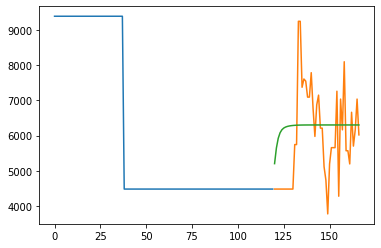

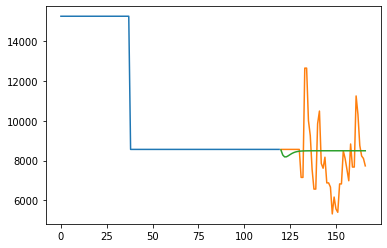

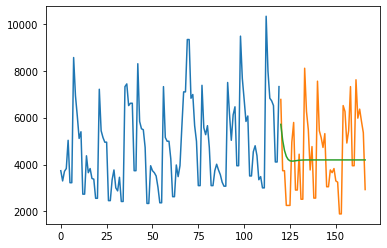

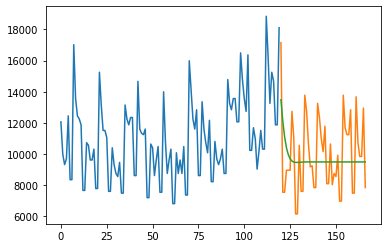

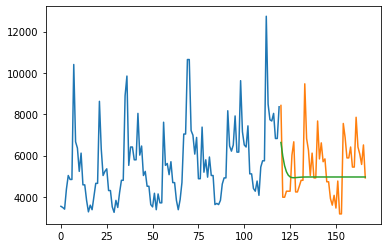

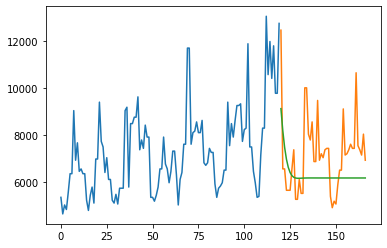

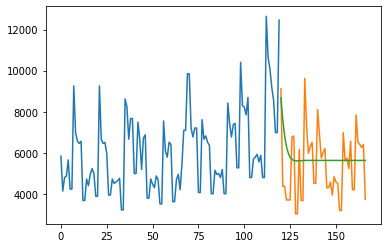

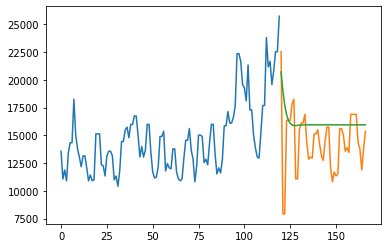

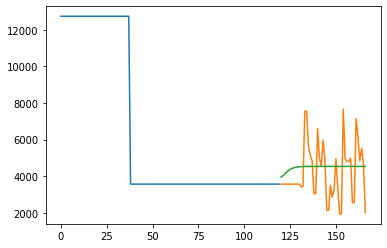

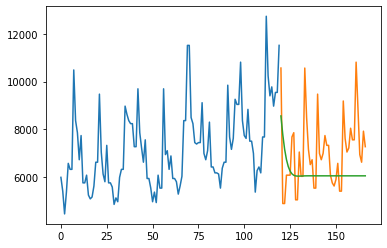

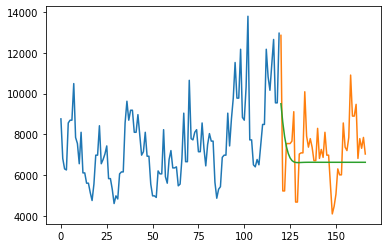

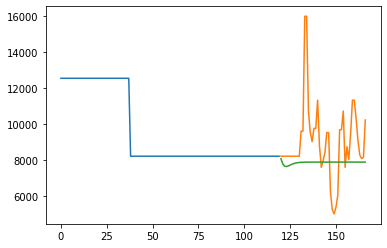

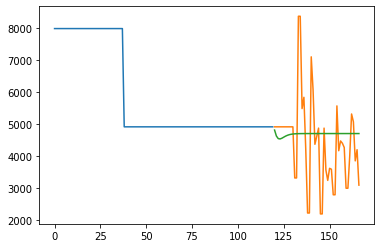

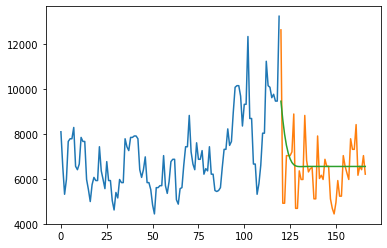

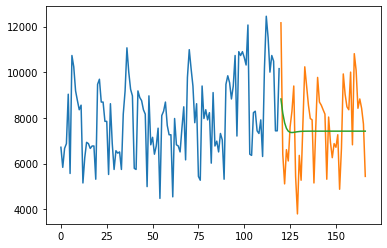

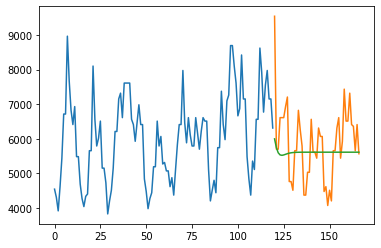

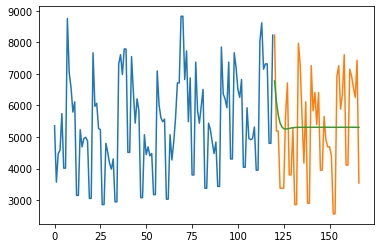

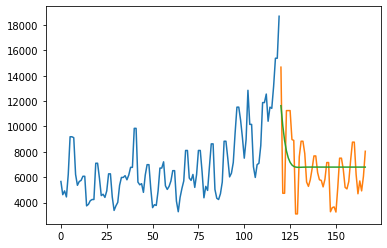

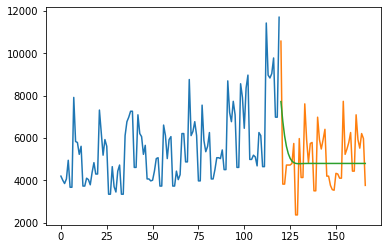

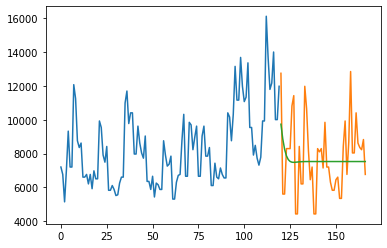

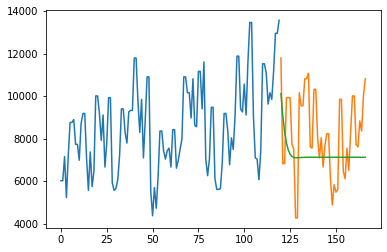

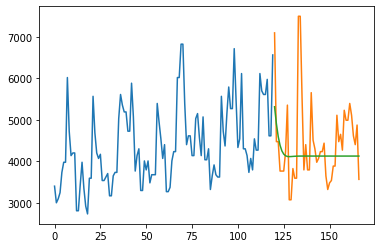

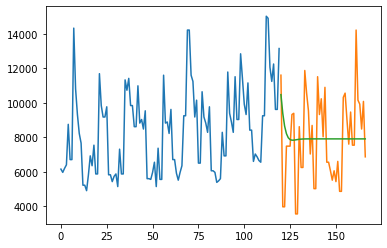

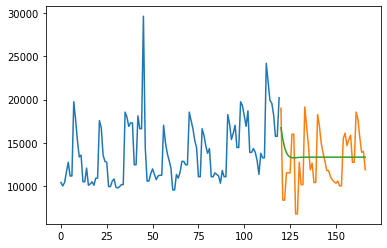

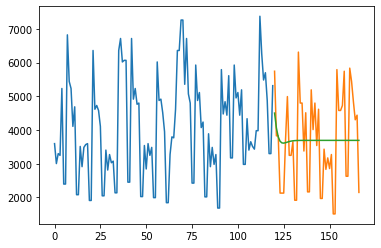

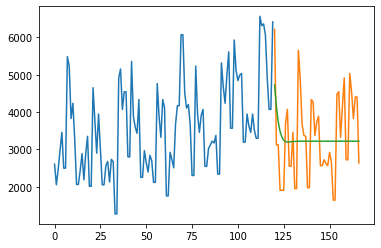

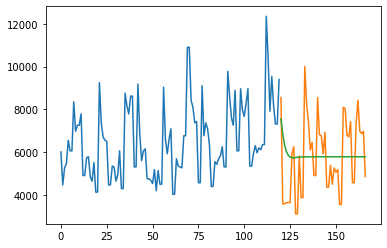

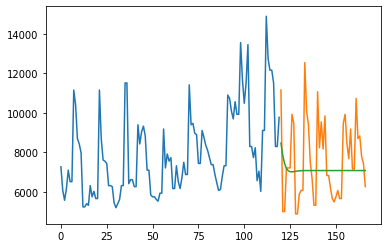

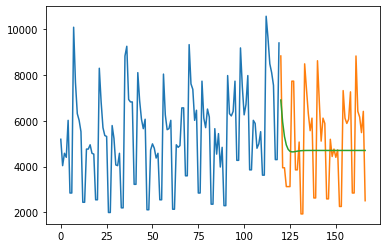

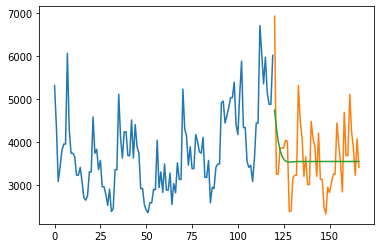

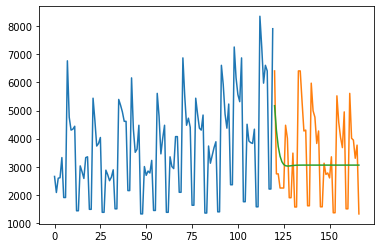

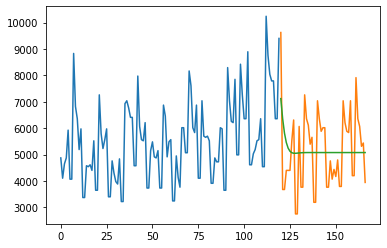

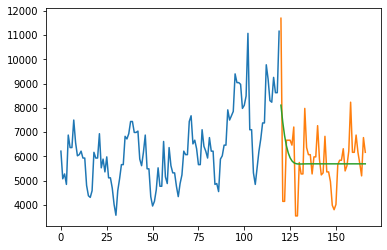

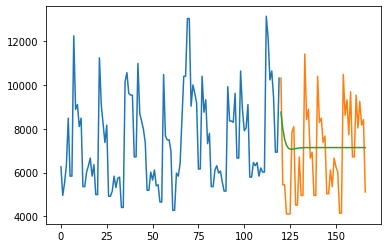

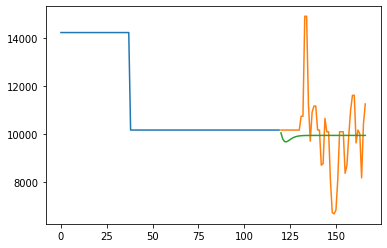

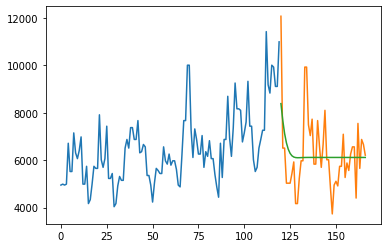

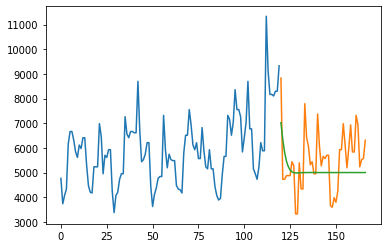

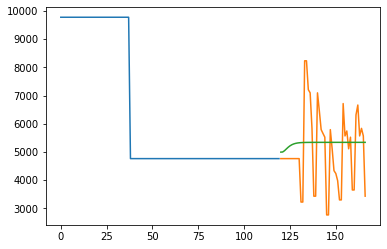

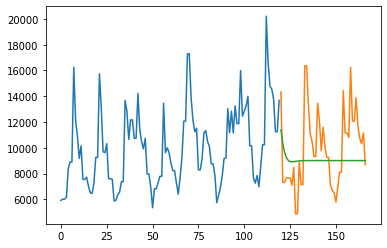

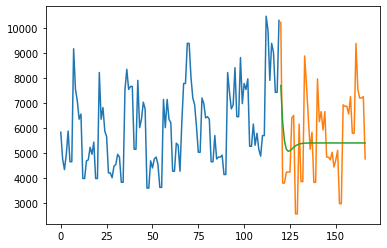

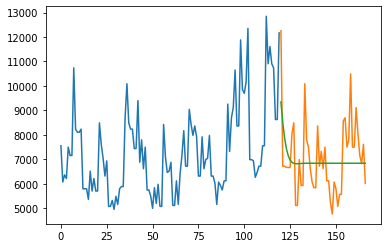

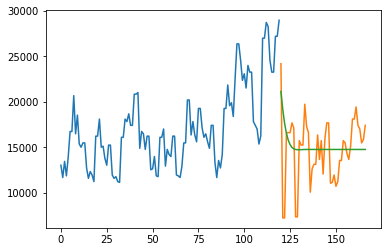

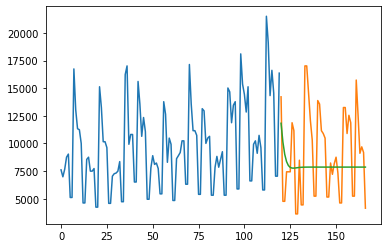

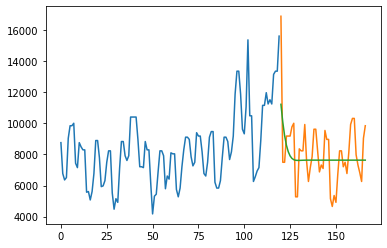

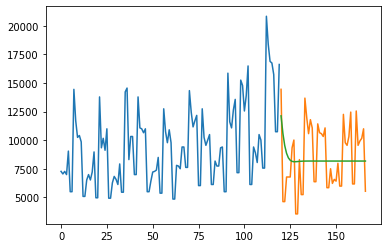

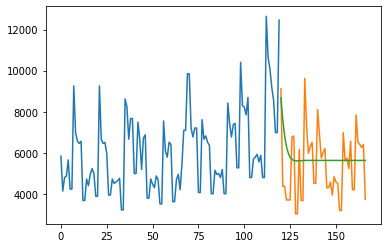

In [184]:
for store in store_sample:
    row = valid_rescaled[valid_rescaled['Store'] == store][['X', 'Y', 'predictions', 'Date', 'Store']].iloc[-10]
    plt.plot(range(120), row['X'])
    plt.plot(range(120, 167), row['Y'])
    plt.plot(range(120, 167), row['predictions'])
    plt.show()

In [189]:
def generate_flat_df(sequence_data, predict_col='predictions', actual_col='Y'):
    flat_df = pd.DataFrame()
    for i, row in sequence_data.iterrows():
        row_df = pd.DataFrame()
        start_date = row['Date']
        row_df['Date'] = pd.date_range(start_date, periods=47).date.tolist()
        row_df['Store'] = row['Store']
        row_df['predictions'] = row[predict_col]
        if actual_col:
            row_df['Sales'] = row[actual_col]
        flat_df = pd.concat([flat_df, row_df], ignore_index=False)
    flat_df.index = range(len(flat_df))
    flat_df['Date'] = pd.to_datetime(flat_df['Date'])
    return flat_df

In [190]:
if mode == 'val':
    valid_sequence_data_sample = valid_rescaled[valid_rescaled['Date'] == '2015-01-01']
    valid_predict_df = generate_flat_df(valid_sequence_data_sample)

In [192]:
test_predict_df = generate_flat_df(test_rescaled, actual_col=None)

In [193]:
test_predict_df

,Date,Store,predictions
0,2015-08-01,9,7331.686251
1,2015-08-02,9,6803.340523
2,2015-08-03,9,6431.888727
3,2015-08-04,9,6204.254926
4,2015-08-05,9,6079.672672
...,...,...,...
3144,2015-09-12,998,4128.941054
3145,2015-09-13,998,4128.941054
3146,2015-09-14,998,4128.941054
3147,2015-09-15,998,4128.941054


### Model evaluation

In [194]:
def rmse(y_hat, y):
    return np.mean(np.sqrt(y_hat - y))

In [195]:
rmse(valid_predict_df['predictions'],valid_predict_df['Sales'])

/Users/kfrid/Projects/takehome_test/venv/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


32.166840918593245

### Submission 

In [196]:
test_predict_df = test_predict_df.merge(test_df, on=['Date', 'Store'])

In [198]:
test_predict_df.to_csv('submission.csv')